In [1]:
import os
import time
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from torchviz import make_dot
from PIL import Image
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torch import optim
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from torchsummary import summary
from Models import CNNModel1_RES
from torch.utils.tensorboard import SummaryWriter
import cv2
from CustDataset import CustDataset
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import StratifiedKFold, KFold
from ray.air import session
from ray.train import Checkpoint
from functools import partial
from sklearn.metrics import balanced_accuracy_score,  f1_score
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
import pandas as pd

# Transfer Learning- ResNet18

Utils:

In [3]:
dir=r"C:\Users\margh\Desktop\ML2\ML2\Project\project 2\train" 
#Utils:
trans_dic2 = {  #for plotting
    0: 'astilbe',
    1: 'bellflower',
    2: 'black eyed susan',
    3: 'calendula',
    4: 'california poppy',
    5: 'carnation',
    6: 'common_daisy',
    7: 'coreopsis',
    8: 'dandelion',
    9: 'iris',
    10: 'rose',
    11: 'sunflower',
    12: 'tulip',
    13: 'water lily'
}
def show_images(data, num_to_show, ae=False, standardized=False):
    """Function that plots images, in case they have been standardized images are rescaled in [0,1]."""
    plt.figure(figsize = (20, 7))
    for i in range(num_to_show):
        if(ae):
            img=data[i]
        else:
            img=data[i][0]
        if(standardized):
             img=torch.clamp(img, min=0, max=1)    
        image = (img).permute((1, 2, 0)).numpy().squeeze()  
        if(not ae):
            label = trans_dic2[data[i][1]]
        plt.subplot(2, num_to_show, i + 1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        if(not ae):
            plt.title(str(label))
    plt.tight_layout()
    plt.show()

In [4]:
data = torchvision.datasets.ImageFolder(dir)
print("Total number of samples: ", len(data))

Total number of samples:  13642


# Data preprocessing:

Preprocess the data and get train and test data. For preprocessing use ImageNet values of mean and std when  standardizing.

In [5]:
train_indices, test_indices, _, _ = train_test_split(
range(len(data)),
data.targets,
stratify=data.targets,  #ensures equal distribution of the labels in train and test set
test_size=0.25,
shuffle=True, #to endorse randomness
random_state=41
)
#Tranformation for resnet-18:
data_transform_original= transforms.Compose([
     transforms.Resize((224,224)),
     transforms.ToTensor()]) #normalization and conversion to tensor
data_transform_train=transforms.Compose([
     transforms.RandomResizedCrop(224),
     transforms.ToTensor(), #normalization and conversion to tensor
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) #standardization (by channel), use values of ImageNet for standardization 
data_transform_test=transforms.Compose([
     transforms.CenterCrop(224),
     transforms.ToTensor(), #normalization and conversion to tensor
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) #standardization (by channel), use values of ImageNet for standardization 
train_data_sub = torch.utils.data.Subset(data, train_indices)
train_data=CustDataset(subset=train_data_sub,transform=data_transform_train)
test_data_sub = torch.utils.data.Subset(data, test_indices)
test_data=CustDataset(subset=test_data_sub,transform=data_transform_test)
train_data_original=CustDataset(subset=train_data_sub,transform=data_transform_original)
test_data_original=CustDataset(subset=train_data_sub,transform=data_transform_original)
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available
trainloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
testloader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

Show some images from training set before preprocessing (just resized):

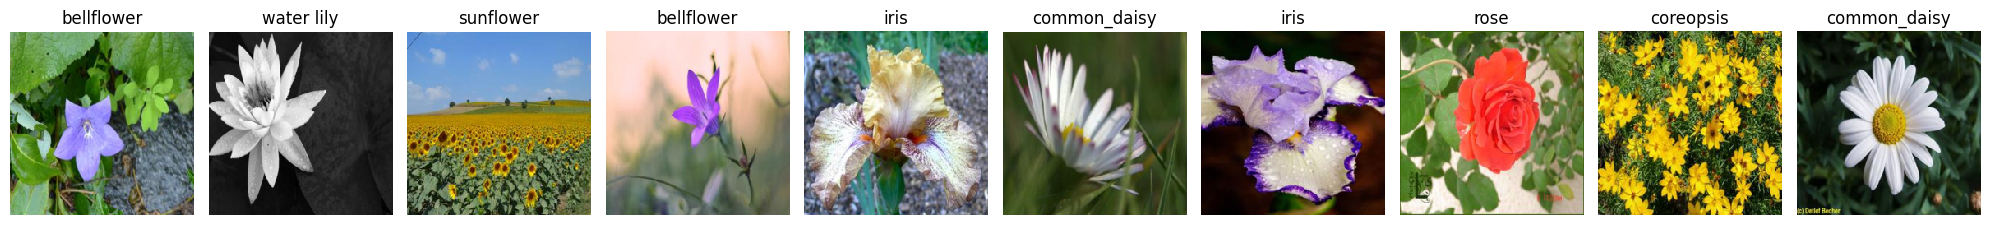

In [6]:
show_images(train_data_original, 10,standardized=True)

Show some preprocessed images from training set:

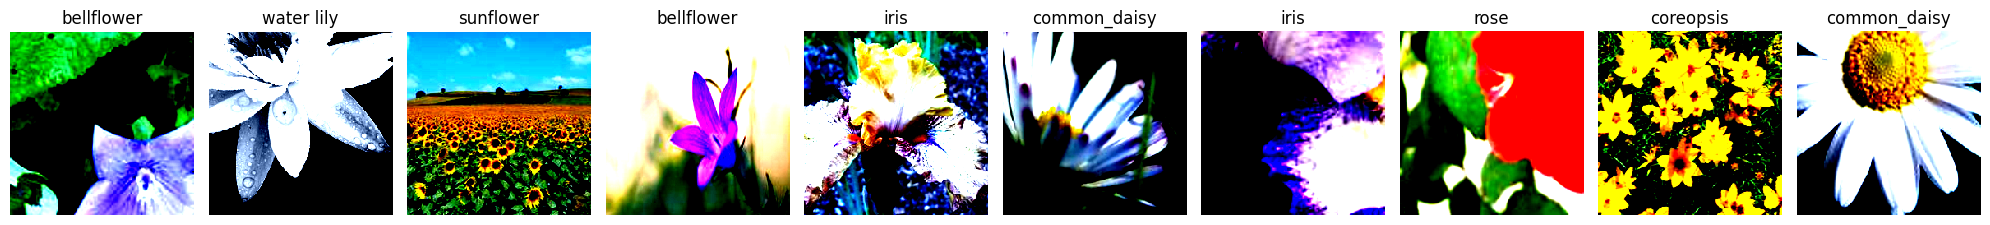

In [7]:
show_images(train_data, 10,standardized=True)

Show some preprocessed images from test set:

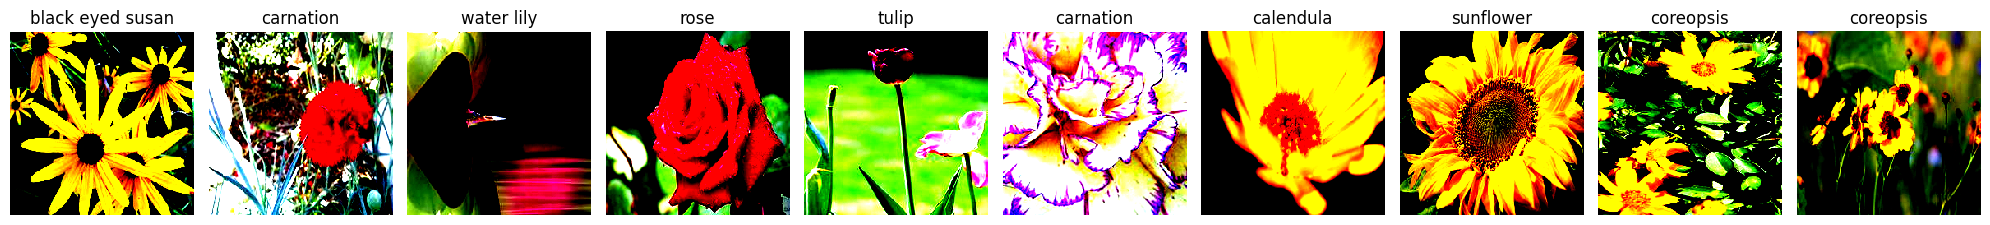

In [8]:
show_images(test_data, 10,standardized=True)

# Set up the model

Model: use pretrained ResNet18 on ImageNet database (more than 1 mln images). I change the last layer to adapt it for the current number of classes and than train it with the rest of the network freezed. I choose a low learning rate not to overwrite the already learnt parameters.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=models.resnet18(weights="IMAGENET1K_V1").to(device)
for param in model.parameters():
    param.requires_grad=False

num_features=model.fc.in_features
model.fc=nn.Sequential(
    nn.Linear(num_features,14) #Softmax applied by the loss function
)
model.fc=model.fc.to(device)
def xavier_normal(layer):  #use normal intialization of weights
    if isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(
            layer.weight
        )
model.fc.apply(xavier_normal)

Sequential(
  (0): Linear(in_features=512, out_features=14, bias=True)
)

# Train and evaluate the model:

The evaluation metric is f1 score as before. Similarly the loss is the cross entropy loss.

In [10]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, weight_decay=0.0001)  #original starting lr=0.1, divided by 10 when error plateaus+ 0.0001 as weight decay.
loss_fun=nn.CrossEntropyLoss

start_epoch=0
train_lossesavg=[]
test_lossesavg=[]
train_accssavg=[]
test_accsavg=[]

y_train=[data.samples[i][1] for i in train_indices] 
y_train=pd.DataFrame(y_train)
y_test=[data.samples[i][1] for i in test_indices] 
y_test=pd.DataFrame(y_test)
classes=list(y_train[0].unique())
class_weights_train=list(class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=np.array(y_train[0])))
class_weights_test=list(class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=np.array(y_test[0])))
for epoch in range(start_epoch, 20): 
    val_accs=[]
    val_losses=[]
    train_accs=[]
    train_losses=[]
    #Train
    model.train()
    for batch in trainloader: 
        classes=np.array(torch.unique(batch[1]))
        if(len(classes)<14):
            continue
        loss_=loss_fun(weight=torch.Tensor(class_weights_train))  #Add weighting to the loss 
        optimizer.zero_grad() 
        input_features = batch[0].to(device)
        target = nn.functional.one_hot(batch[1], 14).to(device)  #One hot  encode for cross entropy loss
        logits = model(input_features)  #Model's output, to get probabilities: call softmax on logits, but in pytorch loss fun expects the logits --> no need to have them in [0,1]
        ce = loss_(logits, target.float()) # Compute the loss
        ce.backward() # Backpropagate and calculate gradients wrt loss, this go in reverse into the computational graph--> gradient for each weight matrix
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1) #Clip gradients to avoid large gradients (risk: overflow and have to rerune entire training round). Clipping divides by gradient's norm, thus the direction doesn't change
        optimizer.step() # Update model parameters (weights): gradient descent update step 
        train_loss=ce.detach().cpu().item() #Transform loss to scalar
        train_losses.append(train_loss)
        predicted_classes = logits.argmax(axis=1)  #Take as predicted class with highest probability
        observed_classes = target.argmax(axis=1)
        sample_class_weights=[class_weights_train[i] for i in observed_classes]  #To compute balanced accuracy
        f1_score_train=f1_score(y_true=observed_classes,y_pred=predicted_classes,average='weighted', sample_weight=sample_class_weights)
        train_accs.append(f1_score_train)
    # Validation
    for batch in testloader:
        model.eval()
        with torch.no_grad():
            classes=np.array(torch.unique(batch[1]))
            if(len(classes)<14):
                continue
            loss_=loss_fun()
            input_features = batch[0].to(device)
            target = nn.functional.one_hot(batch[1], 14).to(device) 
            logits = model(input_features) 
            ce = loss_(logits, target.float()) 
            val_loss=ce.detach().cpu().item()
            val_losses.append(val_loss)
            predicted_classes = logits.argmax(axis=1) 
            observed_classes = target.argmax(axis=1)
            sample_class_weights=[class_weights_test[i] for i in observed_classes] 
            f1_score_val=f1_score(y_true=observed_classes,y_pred=predicted_classes,average='weighted', sample_weight=sample_class_weights)
            val_accs.append(f1_score_val)
    train_lossesavg.append(np.mean(train_losses))
    train_accssavg.append(np.mean(train_accs))
    test_lossesavg.append(np.mean(val_losses))
    test_accsavg.append(np.mean(val_accs))
    print(f"epoch: {epoch + 1}/{20}, train_f1_score: {np.mean(train_accs)}, test_f1_score: {np.mean(val_accs)}")
print("Finished Training")

epoch: 1/20, train_f1_score: 0.10428703389491108, test_f1_score: 0.15764799448341849
epoch: 2/20, train_f1_score: 0.20453780732207433, test_f1_score: 0.2677138400725096
epoch: 3/20, train_f1_score: 0.32822860530485964, test_f1_score: 0.39735991073040156
epoch: 4/20, train_f1_score: 0.4472293390553089, test_f1_score: 0.5139145034010267
epoch: 5/20, train_f1_score: 0.5395945261843578, test_f1_score: 0.5876579515817371
epoch: 6/20, train_f1_score: 0.6101873326783169, test_f1_score: 0.6470772783790991
epoch: 7/20, train_f1_score: 0.6545081378578657, test_f1_score: 0.6903116911629369
epoch: 8/20, train_f1_score: 0.682775865438104, test_f1_score: 0.7169906768514439
epoch: 9/20, train_f1_score: 0.7153488840792294, test_f1_score: 0.7411154600028602
epoch: 10/20, train_f1_score: 0.7336676530834432, test_f1_score: 0.7546756934332689
epoch: 11/20, train_f1_score: 0.7503725237567554, test_f1_score: 0.7736825158539624
epoch: 12/20, train_f1_score: 0.7677914986437349, test_f1_score: 0.78535506104419

Text(0.5, 0, 'epoch')

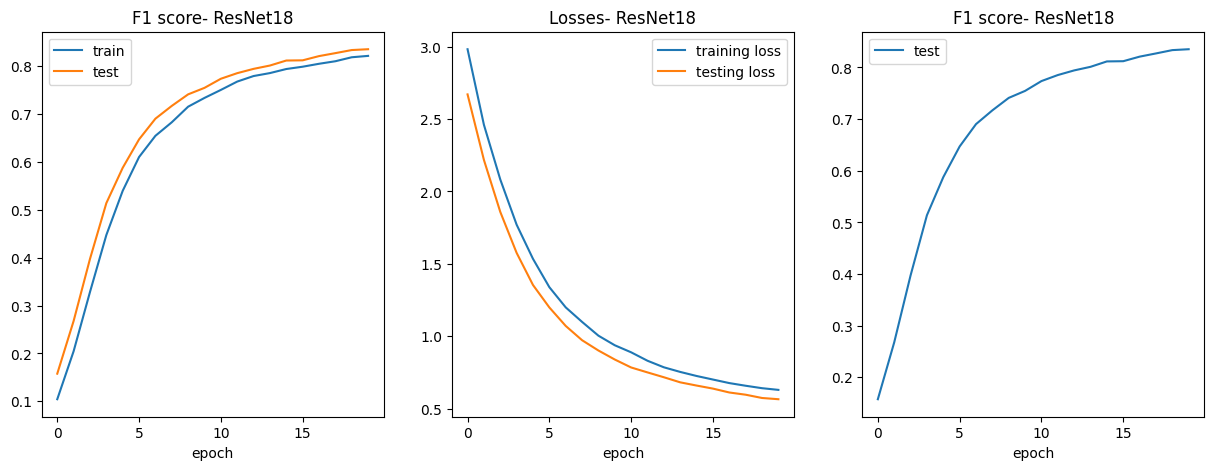

In [13]:
n=20
fig, ax=plt.subplots(1,3, figsize=(15,5))
ax[0].plot(list(range(len(train_accssavg[:n]))), train_accssavg[:n], label="train")
ax[0].plot(list(range(len(test_accsavg[:n]))), test_accsavg[:n], label="test") 
ax[0].legend(loc='best')
ax[0].set_title("F1 score- ResNet18")
ax[0].set_xlabel("epoch")
ax[1].set_xlabel("epoch")
ax[1].plot(list(range(len(train_lossesavg[:n]))), train_lossesavg[:n], label="training loss")
ax[1].plot(list(range(len(test_lossesavg[:n]))), test_lossesavg[:n], label="testing loss")
ax[1].legend(loc='best')
ax[1].set_title("Losses- ResNet18")
ax[1].set_xlabel("epoch")
ax[2].plot(list(range(len(test_accsavg[:n]))), test_accsavg[:n], label="test") 
ax[2].legend(loc='best')
ax[2].set_title("F1 score- ResNet18")
ax[2].set_xlabel("epoch")

In [20]:
torch.save(model.state_dict(), "resnet18_finalweights.pth")
#model.load_state_dict(torch.load("resnet18_finalweights.pth"))

Evaluate the model on the entire test set:

In [14]:
y_pred_=[]
y_test=[]
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        y_test.extend(labels)
        outputs = model(inputs)
        predicted = outputs.argmax(axis=1)
        y_pred_.extend(list(predicted.numpy()))
        del inputs, outputs
class_weights_test=class_weight.compute_class_weight(class_weight='balanced', classes=list(set(y_test)), y=y_test)
sample_class_weights=[class_weights_test[i] for i in y_test]
f1_score_=f1_score(y_true=y_test,y_pred=y_pred_,sample_weight=sample_class_weights, average='weighted')
print('F1 score on test data: {}'.format(f1_score_))


F1 score on test data: 0.8369604755186864 %


Visualize some predictions:

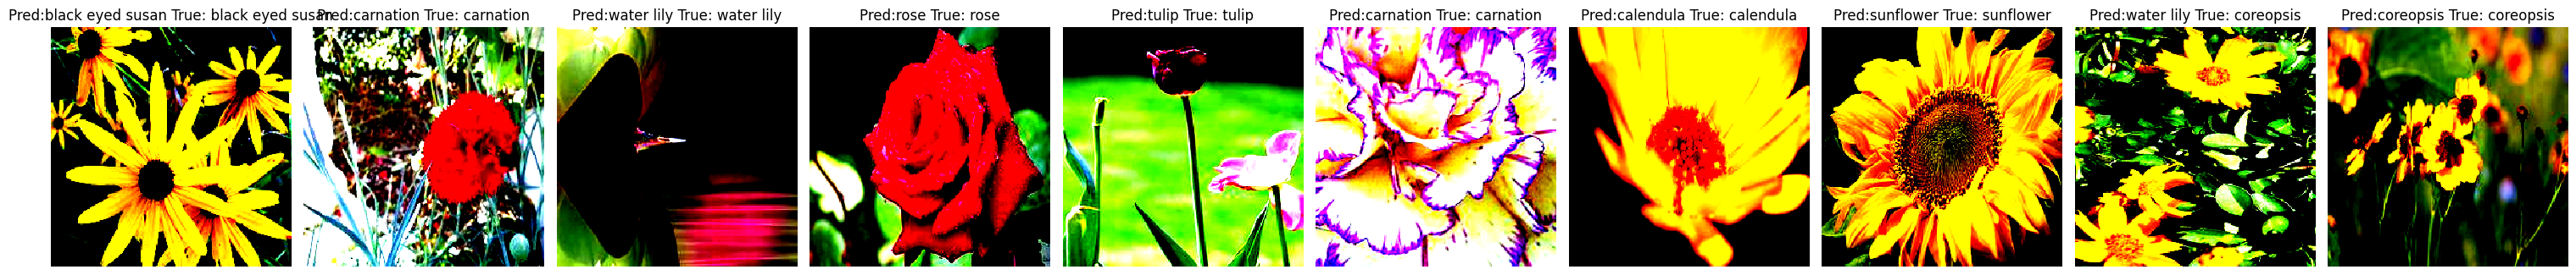

In [23]:
num_to_show = 10
plt.figure(figsize = (30, 30))
for i in range(num_to_show):
    input=test_data[i][0].unsqueeze(0).to(device)
    pred_label=model(input).argmax(axis=1)
    image = test_data[i][0].permute(1,2,0)
    image=torch.clamp(image, min=0, max=1) 
    image=image.numpy()
    true_label = trans_dic2[test_data[i][1]]
    plt.subplot(1, num_to_show, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    title="Pred:"+str(trans_dic2[pred_label.numpy()[0]])+" True: "+str(true_label)
    plt.title(title)
plt.tight_layout()
plt.show()

Confusion matrix:

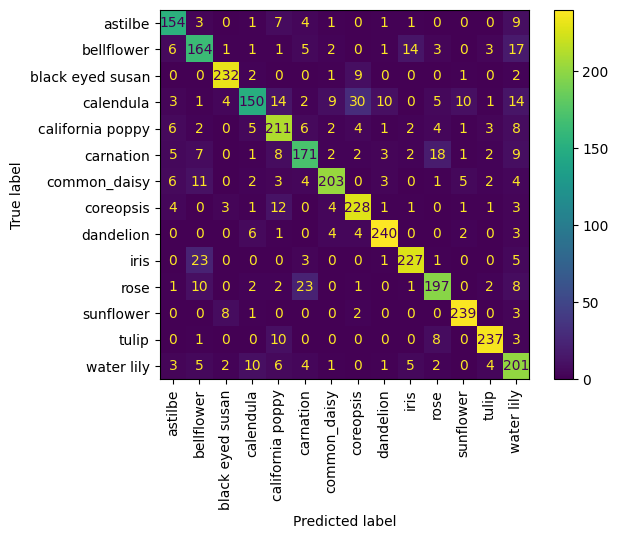

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
labs=list(set(y_test))
cf_matrix=confusion_matrix(y_test, y_pred_)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=trans_dic2.values())
disp.plot(xticks_rotation='vertical')
plt.show()